In [124]:
import os
import clip
import torch
from PIL import Image
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from torch.utils.data import Subset
from tqdm import tqdm
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import random
from sklearn.model_selection import train_test_split, GridSearchCV

print(f'{torch.__version__}')



# 深度學習函式庫
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
print(f'{tensorflow.__version__}')
tensorflow.config.experimental_run_functions_eagerly = False


1.7.1
2.4.0


In [57]:
csv_path = '/tf/Datasets/TBrain_Orchid/label.csv'
img_root = '/tf/Datasets/TBrain_Orchid/training'


In [ ]:
# CLIP preprocess

In [11]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
    transforms.RandomCrop((224, 224)),
#     transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.0)], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(30)], p=0.5),
    transforms.ToTensor(), # 轉為torch tensor並歸一化
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]),
])
val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
    transforms.RandomCrop((224, 224)),
#     transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)], p=0.5),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomApply([transforms.RandomRotation(30)], p=0.5),
    transforms.ToTensor(), # 轉為torch tensor並歸一化
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]),
])

In [12]:
# 若沒有使用外部transform, 則需要自己將feature和label轉為torch.tensor
# 要注意pytorch的影像格式是(3, 224, 224), 跟其他不一樣
# 圖片照類別分在不同資料夾, 因此CSV中的檔名已經是完整路徑
class CustomDatasetFromImages(Dataset):
    def __init__(self, csv_path, img_root, transform=None, target_transform=None, repeat=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.transform = transform
        # Target_transform
        self.target_transform = target_transform
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Repeat for data augmentation
        self.repeat = repeat
        
        # Calculate len
        self.len = len(self.data_info.index)


    def __getitem__(self, i):
        iter_num = (i // self.len) + 1
        index = (i % self.len)
#         print("iters={},index={}".format(iter_num, index))
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        single_image_name = os.path.join(img_root, single_image_name) # csv檔名若已經是完整路徑, 不用再加
        # Open image
        img = Image.open(single_image_name).convert('RGB') # 讀檔時轉為RGB
        
        # If there is an transform
        if self.transform:
            img = self.transform(img)
#         if self.target_transform:
#             label = self.target_transform(label)
        
        # Transform image to tensor
#         img_as_tensor = self.to_tensor(img_as_img)
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img, single_image_label)

    def __len__(self):
        if self.repeat == None:
            self.data_len = 10000000 # 設定成無限迴圈生成資料,以num_epoc和max_iteration來決定跳出
        else:
            self.data_len = self.len * self.repeat
        return self.data_len


In [13]:
# Linear Probe 只用image-encoder, 沒用到text-encoder
def get_features(dataset, epoch_num=1):
    all_features = []
    all_labels = []
    epoch_num = epoch_num #總樣本迴圈次數
    batch_size = 100 
    train_data_nums = dataset.len
    max_iterate = int((train_data_nums+batch_size-1)/batch_size*epoch_num) #總迭代次數
    
    
    with torch.no_grad():
        for steps, (images, labels) in tqdm(enumerate(DataLoader(dataset, batch_size=batch_size))):
            features = model.encode_image(images.to(device))
            print(f'Steps: {steps}')
            all_features.append(features)
            all_labels.append(labels)
            
            if (steps+1) == max_iterate:
                break

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [14]:
# Load the model, 可改其他model
device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load('ViT-B/32', device)
model, preprocess = clip.load('ViT-L/14', device) 

In [15]:
# Call dataset
# dataset =  CustomDatasetFromImages(csv_path=csv_path, img_root=img_root, transform=preprocess)
dataset =  CustomDatasetFromImages(csv_path=csv_path, img_root=img_root)

In [16]:
# 在Data augmentation前要先切好train-test
# 依照label比例分割, 讓train和val中各類別比例一樣
#Split dataset into train and validation

class CustomSubset(Subset):
    '''A custom subset class with customizable data transformation'''
    def __init__(self, dataset, indices, subset_transform=None, repeat=None):
        super().__init__(dataset, indices)
#         self.targets = dataset.targets
#         self.classes = dataset.classes
        self.subset_transform = subset_transform
        self.repeat = repeat
        self.len = len(indices)
 
    def __getitem__(self, i):
        index = (i % self.len)
        x, y = self.dataset[self.indices[index]]
        
        if self.subset_transform:
            x = self.subset_transform(x)
      
        return x, y   
    
    def __len__(self): 
        if self.repeat == None: # trainset
            self.subdata_len = 10000000 # 設定成無限迴圈生成資料,以num_epoc和max_iteration來決定跳出
        else: # val/test set
            self.subdata_len = self.len * self.repeat
        return self.subdata_len

train_indices, val_indices = train_test_split(list(range(len(dataset.label_arr))), test_size=0.3, stratify=dataset.label_arr, random_state=0)
train_dataset = CustomSubset(dataset, train_indices, repeat=None)
val_dataset = CustomSubset(dataset, val_indices, repeat=1)
# 設定train/val各自的preprocess
train_dataset.subset_transform = train_transform
val_dataset.subset_transform = val_transform
# train_dataset.subset_transform = preprocess
# val_dataset.subset_transform = preprocess

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([55])


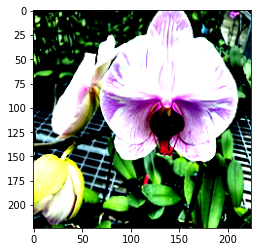

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([111])


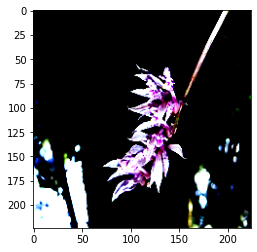

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([64])


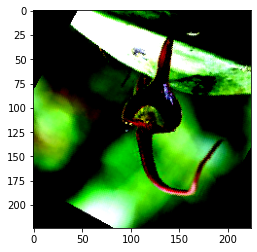

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([194])


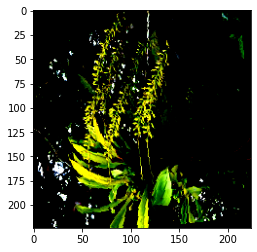

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([47])


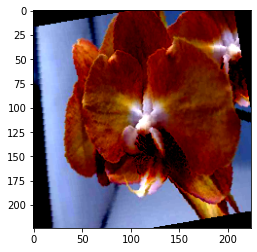

In [17]:
# 測試讀取dataset中資料
cnt = 0
for image, label in DataLoader(train_dataset, batch_size=1):
    print(label)
    img = image[0]
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.show()
    cnt += 1
    if cnt == 5:
        break

In [78]:
import time
# Calculate the image features
start = time.time()
train_features, train_labels = get_features(train_dataset, epoch_num=10)
val_features, val_labels = get_features(val_dataset, epoch_num=1)
end = time.time()
print(f'Time: {end-start}')

1it [00:05,  5.68s/it]

Steps: 0


2it [00:11,  5.58s/it]

Steps: 1


3it [00:16,  5.54s/it]

Steps: 2


4it [00:22,  5.53s/it]

Steps: 3


5it [00:27,  5.52s/it]

Steps: 4


6it [00:33,  5.52s/it]

Steps: 5


7it [00:38,  5.53s/it]

Steps: 6


8it [00:44,  5.54s/it]

Steps: 7


9it [00:49,  5.55s/it]

Steps: 8


10it [00:55,  5.55s/it]

Steps: 9


11it [01:01,  5.57s/it]

Steps: 10


12it [01:06,  5.59s/it]

Steps: 11


13it [01:12,  5.70s/it]

Steps: 12


14it [01:18,  5.77s/it]

Steps: 13


15it [01:24,  5.81s/it]

Steps: 14


16it [01:30,  5.84s/it]

Steps: 15


17it [01:36,  5.85s/it]

Steps: 16


18it [01:42,  5.87s/it]

Steps: 17


19it [01:48,  5.88s/it]

Steps: 18


20it [01:54,  5.90s/it]

Steps: 19


21it [01:59,  5.90s/it]

Steps: 20


22it [02:05,  5.91s/it]

Steps: 21


23it [02:11,  5.91s/it]

Steps: 22


24it [02:17,  5.91s/it]

Steps: 23


25it [02:23,  5.93s/it]

Steps: 24


26it [02:29,  5.93s/it]

Steps: 25


27it [02:35,  5.94s/it]

Steps: 26


28it [02:41,  5.94s/it]

Steps: 27


29it [02:47,  5.93s/it]

Steps: 28


30it [02:53,  5.93s/it]

Steps: 29


31it [02:59,  5.93s/it]

Steps: 30


32it [03:05,  5.92s/it]

Steps: 31


33it [03:11,  5.92s/it]

Steps: 32


34it [03:17,  5.92s/it]

Steps: 33


35it [03:22,  5.93s/it]

Steps: 34


36it [03:28,  5.93s/it]

Steps: 35


37it [03:34,  5.92s/it]

Steps: 36


38it [03:40,  5.91s/it]

Steps: 37


39it [03:46,  5.92s/it]

Steps: 38


40it [03:52,  5.91s/it]

Steps: 39


41it [03:58,  5.91s/it]

Steps: 40


42it [04:04,  5.91s/it]

Steps: 41


43it [04:10,  5.91s/it]

Steps: 42


44it [04:16,  5.92s/it]

Steps: 43


45it [04:22,  5.92s/it]

Steps: 44


46it [04:28,  5.93s/it]

Steps: 45


47it [04:33,  5.92s/it]

Steps: 46


48it [04:39,  5.92s/it]

Steps: 47


49it [04:45,  5.92s/it]

Steps: 48


50it [04:51,  5.93s/it]

Steps: 49


51it [04:57,  5.93s/it]

Steps: 50


52it [05:03,  5.93s/it]

Steps: 51


53it [05:09,  5.92s/it]

Steps: 52


54it [05:15,  5.91s/it]

Steps: 53


55it [05:21,  5.96s/it]

Steps: 54


56it [05:27,  5.96s/it]

Steps: 55


57it [05:33,  5.95s/it]

Steps: 56


58it [05:39,  5.94s/it]

Steps: 57


59it [05:45,  5.93s/it]

Steps: 58


60it [05:51,  5.92s/it]

Steps: 59


61it [05:57,  5.92s/it]

Steps: 60


62it [06:02,  5.92s/it]

Steps: 61


63it [06:08,  5.96s/it]

Steps: 62


64it [06:14,  5.95s/it]

Steps: 63


65it [06:20,  5.93s/it]

Steps: 64


66it [06:26,  5.93s/it]

Steps: 65


67it [06:32,  5.92s/it]

Steps: 66


68it [06:38,  5.92s/it]

Steps: 67


69it [06:44,  5.92s/it]

Steps: 68


70it [06:50,  5.92s/it]

Steps: 69


71it [06:56,  5.92s/it]

Steps: 70


72it [07:02,  5.92s/it]

Steps: 71


73it [07:08,  5.92s/it]

Steps: 72


74it [07:14,  5.92s/it]

Steps: 73


75it [07:19,  5.92s/it]

Steps: 74


76it [07:25,  5.91s/it]

Steps: 75


77it [07:31,  5.93s/it]

Steps: 76


78it [07:37,  5.92s/it]

Steps: 77


79it [07:43,  5.92s/it]

Steps: 78


80it [07:49,  5.93s/it]

Steps: 79


81it [07:55,  5.92s/it]

Steps: 80


82it [08:01,  5.92s/it]

Steps: 81


83it [08:07,  5.92s/it]

Steps: 82


84it [08:13,  5.92s/it]

Steps: 83


85it [08:19,  5.92s/it]

Steps: 84


86it [08:25,  5.92s/it]

Steps: 85


87it [08:30,  5.91s/it]

Steps: 86


88it [08:36,  5.91s/it]

Steps: 87


89it [08:42,  5.91s/it]

Steps: 88


90it [08:48,  5.91s/it]

Steps: 89


91it [08:54,  5.92s/it]

Steps: 90


92it [09:00,  5.93s/it]

Steps: 91


93it [09:06,  5.92s/it]

Steps: 92


94it [09:12,  5.91s/it]

Steps: 93


95it [09:18,  5.91s/it]

Steps: 94


96it [09:24,  5.91s/it]

Steps: 95


97it [09:30,  5.91s/it]

Steps: 96


98it [09:36,  5.93s/it]

Steps: 97


99it [09:42,  5.92s/it]

Steps: 98


100it [09:47,  5.92s/it]

Steps: 99


101it [09:53,  5.91s/it]

Steps: 100


102it [09:59,  5.91s/it]

Steps: 101


103it [10:05,  5.91s/it]

Steps: 102


104it [10:11,  5.91s/it]

Steps: 103


105it [10:17,  5.91s/it]

Steps: 104


106it [10:23,  5.91s/it]

Steps: 105


107it [10:29,  5.91s/it]

Steps: 106


108it [10:35,  5.90s/it]

Steps: 107


109it [10:41,  5.91s/it]

Steps: 108


110it [10:46,  5.90s/it]

Steps: 109


111it [10:52,  5.90s/it]

Steps: 110


112it [10:58,  5.90s/it]

Steps: 111


113it [11:04,  5.90s/it]

Steps: 112


114it [11:10,  5.90s/it]

Steps: 113


115it [11:16,  5.90s/it]

Steps: 114


116it [11:22,  5.91s/it]

Steps: 115


117it [11:28,  5.91s/it]

Steps: 116


118it [11:34,  5.91s/it]

Steps: 117


119it [11:40,  5.92s/it]

Steps: 118


120it [11:46,  5.91s/it]

Steps: 119


121it [11:51,  5.90s/it]

Steps: 120


122it [11:57,  5.91s/it]

Steps: 121


123it [12:03,  5.91s/it]

Steps: 122


124it [12:09,  5.91s/it]

Steps: 123


125it [12:15,  5.90s/it]

Steps: 124


126it [12:21,  5.91s/it]

Steps: 125


127it [12:27,  5.90s/it]

Steps: 126


128it [12:33,  5.90s/it]

Steps: 127


129it [12:39,  5.91s/it]

Steps: 128


130it [12:45,  5.91s/it]

Steps: 129


131it [12:51,  5.92s/it]

Steps: 130


132it [12:57,  5.97s/it]

Steps: 131


133it [13:03,  5.94s/it]

Steps: 132


134it [13:08,  5.93s/it]

Steps: 133


135it [13:14,  5.93s/it]

Steps: 134


136it [13:20,  5.92s/it]

Steps: 135


137it [13:26,  5.93s/it]

Steps: 136


138it [13:32,  5.92s/it]

Steps: 137


139it [13:38,  5.91s/it]

Steps: 138


140it [13:44,  5.92s/it]

Steps: 139


141it [13:50,  5.91s/it]

Steps: 140


142it [13:56,  5.91s/it]

Steps: 141


143it [14:02,  5.90s/it]

Steps: 142


144it [14:07,  5.90s/it]

Steps: 143


145it [14:13,  5.90s/it]

Steps: 144


146it [14:19,  5.90s/it]

Steps: 145


147it [14:25,  5.89s/it]

Steps: 146


148it [14:31,  5.89s/it]

Steps: 147


149it [14:37,  5.89s/it]

Steps: 148


150it [14:43,  5.89s/it]

Steps: 149


151it [14:49,  5.95s/it]

Steps: 150


152it [14:55,  5.95s/it]

Steps: 151


153it [15:01,  5.93s/it]

Steps: 152


154it [15:07,  5.92s/it]

Steps: 153


155it [15:13,  5.91s/it]

Steps: 154


156it [15:18,  5.90s/it]

Steps: 155


157it [15:24,  5.90s/it]

Steps: 156


158it [15:30,  5.89s/it]

Steps: 157


159it [15:36,  5.89s/it]

Steps: 158


160it [15:42,  5.89s/it]

Steps: 159


161it [15:48,  5.89s/it]

Steps: 160


162it [15:54,  5.89s/it]

Steps: 161


162it [16:00,  5.93s/it]

Steps: 162



1it [00:05,  5.75s/it]

Steps: 0


2it [00:11,  5.77s/it]

Steps: 1


3it [00:17,  5.78s/it]

Steps: 2


4it [00:23,  5.78s/it]

Steps: 3


5it [00:28,  5.78s/it]

Steps: 4


6it [00:34,  5.78s/it]

Steps: 5


6it [00:37,  6.28s/it]

Steps: 6
Time: 998.0931854248047


In [79]:
# np.save('train_features_ViTB32', train_features)
# np.save('train_labels_ViTB32', train_labels)
# np.save('val_features_ViTB32', val_features)
# np.save('val_labels_ViTB32', val_labels)

np.save('train_features_ViTB32_DA2', train_features)
np.save('train_labels_ViTB32_DA2', train_labels)
np.save('val_features_ViTB32_DA2', val_features)
np.save('val_labels_ViTB32_DA2', val_labels)

## 分類器訓練

### 普通建模

In [141]:
inputs = Input(shape=(768,)) # CLIP output 的Embedding維度

x = Dense(1024, activation='relu')(inputs) #1
x = Activation('relu')(x)
x = Dense(1024, activation='relu')(inputs) #1
x = Activation('relu')(x)
x = Dense(1024, activation='relu')(inputs) #1
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# 添加一个分类器
predictions = Dense(219, activation='softmax')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=inputs, outputs=predictions)
print(model.summary())

optimizer = Adam(lr=5e-5,decay=0.0001,beta_1=0.9,beta_2=0.999) #100e-6
# optimizer = SGD(lr=1e-5, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

epochs = 2000
aug_ratio = 1
batch_size = 32
steps_per_epoch = int(aug_ratio * train_features.shape[0] / batch_size)
save_dir = os.path.join(os.getcwd(), 'saved_models') # 儲存模型的路徑
model_name = 'Model_CLIP.h5' # 模型名稱

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)
earlystop = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1) # patience=10為連續10次模型loss沒再下降就停止

model_history = model.fit(train_features, train_labels_OH, 
                          batch_size = batch_size,
                          epochs = epochs,
                          verbose = True,
                          callbacks = [checkpoint, earlystop],
                          validation_data = (val_features, val_labels_OH),
                          steps_per_epoch=steps_per_epoch
)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              787456    
_________________________________________________________________
activation_8 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 219)               224475    
Total params: 1,011,931
Trainable params: 1,011,931
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2000
509/509 [==============================] - 2s 3ms/step - loss: 5.3031 - accuracy: 0.0215 - val_lo


Epoch 00025: val_loss improved from 0.81572 to 0.79615, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 26/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3670 - accuracy: 0.9336 - val_loss: 0.7830 - val_accuracy: 0.7960

Epoch 00026: val_loss improved from 0.79615 to 0.78299, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 27/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3459 - accuracy: 0.9382 - val_loss: 0.7682 - val_accuracy: 0.8067

Epoch 00027: val_loss improved from 0.78299 to 0.76818, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 28/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3339 - accuracy: 0.9371 - val_loss: 0.7606 - val_accuracy: 0.8006

Epoch 00028: val_loss improved from 0.76818 to 0.76059, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognit


Epoch 00053: val_loss did not improve from 0.61849
Epoch 54/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.1462 - accuracy: 0.9785 - val_loss: 0.6177 - val_accuracy: 0.8326

Epoch 00054: val_loss improved from 0.61849 to 0.61774, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 55/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.1387 - accuracy: 0.9805 - val_loss: 0.6121 - val_accuracy: 0.8280

Epoch 00055: val_loss improved from 0.61774 to 0.61207, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 56/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.1311 - accuracy: 0.9822 - val_loss: 0.6137 - val_accuracy: 0.8234

Epoch 00056: val_loss did not improve from 0.61207
Epoch 57/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.1333 - accuracy: 0.9819 - val_loss: 0.6075 - val_accuracy: 0.8280

Epoch 00057: val_

509/509 [==============================] - 1s 3ms/step - loss: 0.0841 - accuracy: 0.9885 - val_loss: 0.5741 - val_accuracy: 0.8387

Epoch 00086: val_loss did not improve from 0.56966
Epoch 87/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.0804 - accuracy: 0.9910 - val_loss: 0.5708 - val_accuracy: 0.8417

Epoch 00087: val_loss did not improve from 0.56966
Epoch 88/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.0792 - accuracy: 0.9913 - val_loss: 0.5680 - val_accuracy: 0.8417

Epoch 00088: val_loss improved from 0.56966 to 0.56796, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 89/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.0777 - accuracy: 0.9897 - val_loss: 0.5674 - val_accuracy: 0.8326

Epoch 00089: val_loss improved from 0.56796 to 0.56742, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 90/2000
509/509 [=========

509/509 [==============================] - 1s 3ms/step - loss: 0.0551 - accuracy: 0.9949 - val_loss: 0.5561 - val_accuracy: 0.8295

Epoch 00122: val_loss did not improve from 0.55261
Epoch 123/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.0561 - accuracy: 0.9925 - val_loss: 0.5536 - val_accuracy: 0.8341

Epoch 00123: val_loss did not improve from 0.55261
Epoch 124/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.0537 - accuracy: 0.9948 - val_loss: 0.5536 - val_accuracy: 0.8417

Epoch 00124: val_loss did not improve from 0.55261
Epoch 125/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.0518 - accuracy: 0.9948 - val_loss: 0.5509 - val_accuracy: 0.8387

Epoch 00125: val_loss improved from 0.55261 to 0.55091, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 126/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.0530 - accuracy: 0.9948 - val_loss: 0.5521 - v

In [142]:
final_model = keras.models.load_model('saved_models/Model_CLIP.h5')
scores = final_model.evaluate(val_features, val_labels_OH)

21/21 [==============================] - 0s 2ms/step - loss: 0.5459 - accuracy: 0.8417


### Keras_Tuner 建模實驗


In [58]:
train_features = np.load('train_features_ViTB32_DA2.npy')
train_labels = np.load('train_labels_ViTB32_DA2.npy')
val_features = np.load('val_features_ViTB32_DA2.npy')
val_labels = np.load('val_labels_ViTB32_DA2.npy')

print(f'train_featrues.shape:{train_features.shape}')
print(f'train_labels.shape:{train_labels.shape}')
print(f'val_features.shape:{val_features.shape}')
print(f'val_labels.shape:{val_labels.shape}')



train_featrues.shape:(16300, 768)
train_labels.shape:(16300,)
val_features.shape:(657, 768)
val_labels.shape:(657,)


In [59]:
# 對 label進行 OneHotEncoding-219類別
train_labels_OH = keras.utils.to_categorical(train_labels, 219)  
print(train_labels_OH.shape)
val_labels_OH = keras.utils.to_categorical(val_labels, 219)  
print(val_labels_OH.shape)

(16300, 219)
(657, 219)


In [125]:
def model_builder(hp):
    inputs = Input(shape=(768,)) # CLIP output 的Embedding維度

    x = Dense(hp.Choice('units', [256, 512, 1024]), activation='relu')(inputs) #1
    x = Activation('relu')(x)
    x = Dropout(rate=hp.Float("rate", min_value=0.0, max_value=0.7, step=0.1))(x)

    # 添加一个分类器
    predictions = Dense(219, activation='softmax')(x)

    # 构建我们需要训练的完整模型
    model = Model(inputs=inputs, outputs=predictions)
    print(model.summary())

    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-4, sampling="log")
    optimizer = Adam(lr=learning_rate,decay=0.0001,beta_1=0.9,beta_2=0.999) #100e-6
    # optimizer = SGD(lr=1e-5, decay=1e-4, momentum=0.9, nesterov=True)
    model.compile(loss = 'categorical_crossentropy',
                 optimizer = optimizer,
                 metrics = ['accuracy'])

    return model

In [126]:
epochs = 2000
aug_ratio = 1
batch_size = 32
steps_per_epoch = int(aug_ratio * train_features.shape[0] / batch_size)
save_dir = os.path.join(os.getcwd(), 'saved_models') # 儲存模型的路徑
model_name = 'Model_CLIP.h5' # 模型名稱

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)
earlystop = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1) # patience=10為連續10次模型loss沒再下降就停止

In [ ]:
tuner = kt.RandomSearch(model_builder, objective='val_loss', max_trials=20)

tuner.search(train_features, train_labels_OH, 
             batch_size = batch_size,
             epochs = epochs,
             verbose = True,
             callbacks = [checkpoint, earlystop],
             validation_data = (val_features, val_labels_OH),
             steps_per_epoch=steps_per_epoch
)

Trial 7 Complete [00h 07m 30s]
val_loss: 0.6191866993904114

Best val_loss So Far: 0.5760288834571838
Total elapsed time: 01h 37m 32s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
512               |1024              |units
0.4               |0.6               |rate
1.4538e-05        |2.5634e-05        |lr

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
________________________________________________

Epoch 52/2000
509/509 [==============================] - 1s 3ms/step - loss: 1.6014 - accuracy: 0.6500 - val_loss: 1.7867 - val_accuracy: 0.6773

Epoch 00052: val_loss improved from 1.80109 to 1.78672, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 53/2000
509/509 [==============================] - 1s 3ms/step - loss: 1.5937 - accuracy: 0.6454 - val_loss: 1.7723 - val_accuracy: 0.6819

Epoch 00053: val_loss improved from 1.78672 to 1.77231, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 54/2000
509/509 [==============================] - 1s 3ms/step - loss: 1.5650 - accuracy: 0.6531 - val_loss: 1.7576 - val_accuracy: 0.6849

Epoch 00054: val_loss improved from 1.77231 to 1.75756, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 55/2000
509/509 [==============================] - 1s 3ms/step - loss: 1.5383 - accuracy: 0.6590 - val_loss: 1.7

Epoch 80/2000
509/509 [==============================] - 1s 2ms/step - loss: 1.2494 - accuracy: 0.7259 - val_loss: 1.4943 - val_accuracy: 0.7093

Epoch 00080: val_loss improved from 1.50161 to 1.49425, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 81/2000
509/509 [==============================] - 1s 3ms/step - loss: 1.2365 - accuracy: 0.7359 - val_loss: 1.4868 - val_accuracy: 0.7123

Epoch 00081: val_loss improved from 1.49425 to 1.48680, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 82/2000
509/509 [==============================] - 1s 3ms/step - loss: 1.2482 - accuracy: 0.7269 - val_loss: 1.4792 - val_accuracy: 0.7108

Epoch 00082: val_loss improved from 1.48680 to 1.47924, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 83/2000
509/509 [==============================] - 1s 2ms/step - loss: 1.2183 - accuracy: 0.7377 - val_loss: 1.4

Epoch 108/2000
509/509 [==============================] - 1s 3ms/step - loss: 1.0523 - accuracy: 0.7753 - val_loss: 1.3307 - val_accuracy: 0.7215

Epoch 00108: val_loss improved from 1.33548 to 1.33074, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 109/2000
509/509 [==============================] - 1s 3ms/step - loss: 1.0513 - accuracy: 0.7789 - val_loss: 1.3261 - val_accuracy: 0.7230

Epoch 00109: val_loss improved from 1.33074 to 1.32607, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 110/2000
509/509 [==============================] - 1s 3ms/step - loss: 1.0482 - accuracy: 0.7755 - val_loss: 1.3217 - val_accuracy: 0.7245

Epoch 00110: val_loss improved from 1.32607 to 1.32170, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 111/2000
509/509 [==============================] - 1s 3ms/step - loss: 1.0312 - accuracy: 0.7837 - val_loss:

Epoch 136/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.9198 - accuracy: 0.8064 - val_loss: 1.2241 - val_accuracy: 0.7367

Epoch 00136: val_loss improved from 1.22732 to 1.22406, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 137/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.9155 - accuracy: 0.8023 - val_loss: 1.2213 - val_accuracy: 0.7352

Epoch 00137: val_loss improved from 1.22406 to 1.22132, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 138/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.9129 - accuracy: 0.8081 - val_loss: 1.2180 - val_accuracy: 0.7352

Epoch 00138: val_loss improved from 1.22132 to 1.21801, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 139/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.9088 - accuracy: 0.8067 - val_loss:

Epoch 164/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.8440 - accuracy: 0.8158 - val_loss: 1.1499 - val_accuracy: 0.7397

Epoch 00164: val_loss improved from 1.15168 to 1.14994, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 165/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.8304 - accuracy: 0.8211 - val_loss: 1.1476 - val_accuracy: 0.7397

Epoch 00165: val_loss improved from 1.14994 to 1.14761, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 166/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.8293 - accuracy: 0.8216 - val_loss: 1.1451 - val_accuracy: 0.7428

Epoch 00166: val_loss improved from 1.14761 to 1.14512, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 167/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.8160 - accuracy: 0.8262 - val_loss:

Epoch 192/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.7679 - accuracy: 0.8398 - val_loss: 1.0932 - val_accuracy: 0.7473

Epoch 00192: val_loss improved from 1.09450 to 1.09321, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 193/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.7546 - accuracy: 0.8396 - val_loss: 1.0912 - val_accuracy: 0.7458

Epoch 00193: val_loss improved from 1.09321 to 1.09123, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 194/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.7563 - accuracy: 0.8450 - val_loss: 1.0897 - val_accuracy: 0.7473

Epoch 00194: val_loss improved from 1.09123 to 1.08971, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 195/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.7614 - accuracy: 0.8387 - val_loss:

509/509 [==============================] - 1s 2ms/step - loss: 0.7076 - accuracy: 0.8541 - val_loss: 1.0493 - val_accuracy: 0.7504

Epoch 00220: val_loss improved from 1.05076 to 1.04934, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 221/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.7000 - accuracy: 0.8564 - val_loss: 1.0482 - val_accuracy: 0.7504

Epoch 00221: val_loss improved from 1.04934 to 1.04819, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 222/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.7039 - accuracy: 0.8544 - val_loss: 1.0466 - val_accuracy: 0.7549

Epoch 00222: val_loss improved from 1.04819 to 1.04656, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 223/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.6972 - accuracy: 0.8574 - val_loss: 1.0449 - val_a

Epoch 248/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.6608 - accuracy: 0.8639 - val_loss: 1.0142 - val_accuracy: 0.7580

Epoch 00248: val_loss improved from 1.01510 to 1.01417, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 249/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.6697 - accuracy: 0.8647 - val_loss: 1.0128 - val_accuracy: 0.7565

Epoch 00249: val_loss improved from 1.01417 to 1.01278, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 250/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.6708 - accuracy: 0.8591 - val_loss: 1.0113 - val_accuracy: 0.7580

Epoch 00250: val_loss improved from 1.01278 to 1.01129, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 251/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.6616 - accuracy: 0.8648 - val_loss:

Epoch 276/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.6221 - accuracy: 0.8767 - val_loss: 0.9841 - val_accuracy: 0.7656

Epoch 00276: val_loss improved from 0.98462 to 0.98410, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 277/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.6229 - accuracy: 0.8694 - val_loss: 0.9831 - val_accuracy: 0.7641

Epoch 00277: val_loss improved from 0.98410 to 0.98305, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 278/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.6380 - accuracy: 0.8693 - val_loss: 0.9823 - val_accuracy: 0.7626

Epoch 00278: val_loss improved from 0.98305 to 0.98229, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 279/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.6200 - accuracy: 0.8746 - val_loss:

Epoch 304/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5956 - accuracy: 0.8789 - val_loss: 0.9595 - val_accuracy: 0.7626

Epoch 00304: val_loss improved from 0.96031 to 0.95953, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 305/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5971 - accuracy: 0.8771 - val_loss: 0.9586 - val_accuracy: 0.7626

Epoch 00305: val_loss improved from 0.95953 to 0.95859, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 306/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.5940 - accuracy: 0.8752 - val_loss: 0.9576 - val_accuracy: 0.7641

Epoch 00306: val_loss improved from 0.95859 to 0.95762, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 307/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5995 - accuracy: 0.8716 - val_loss:

Epoch 332/2000
509/509 [==============================] - 2s 3ms/step - loss: 0.5658 - accuracy: 0.8871 - val_loss: 0.9380 - val_accuracy: 0.7702

Epoch 00332: val_loss improved from 0.93872 to 0.93804, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 333/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.5595 - accuracy: 0.8844 - val_loss: 0.9374 - val_accuracy: 0.7671

Epoch 00333: val_loss improved from 0.93804 to 0.93741, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 334/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5750 - accuracy: 0.8783 - val_loss: 0.9365 - val_accuracy: 0.7686

Epoch 00334: val_loss improved from 0.93741 to 0.93653, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 335/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5830 - accuracy: 0.8777 - val_loss:

Epoch 360/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5520 - accuracy: 0.8885 - val_loss: 0.9199 - val_accuracy: 0.7717

Epoch 00360: val_loss improved from 0.92027 to 0.91993, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 361/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5433 - accuracy: 0.8884 - val_loss: 0.9193 - val_accuracy: 0.7702

Epoch 00361: val_loss improved from 0.91993 to 0.91931, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 362/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.5475 - accuracy: 0.8864 - val_loss: 0.9187 - val_accuracy: 0.7732

Epoch 00362: val_loss improved from 0.91931 to 0.91873, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 363/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.5435 - accuracy: 0.8918 - val_loss:

Epoch 388/2000
509/509 [==============================] - 2s 3ms/step - loss: 0.5274 - accuracy: 0.8959 - val_loss: 0.9034 - val_accuracy: 0.7686

Epoch 00388: val_loss improved from 0.90398 to 0.90341, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 389/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5275 - accuracy: 0.8902 - val_loss: 0.9030 - val_accuracy: 0.7686

Epoch 00389: val_loss improved from 0.90341 to 0.90302, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 390/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.5214 - accuracy: 0.8916 - val_loss: 0.9024 - val_accuracy: 0.7686

Epoch 00390: val_loss improved from 0.90302 to 0.90243, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 391/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5240 - accuracy: 0.8944 - val_loss:

Epoch 416/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5062 - accuracy: 0.8974 - val_loss: 0.8887 - val_accuracy: 0.7763

Epoch 00416: val_loss improved from 0.88936 to 0.88869, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 417/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5120 - accuracy: 0.8937 - val_loss: 0.8882 - val_accuracy: 0.7763

Epoch 00417: val_loss improved from 0.88869 to 0.88817, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 418/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5104 - accuracy: 0.8962 - val_loss: 0.8879 - val_accuracy: 0.7763

Epoch 00418: val_loss improved from 0.88817 to 0.88791, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 419/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.5083 - accuracy: 0.8989 - val_loss:

509/509 [==============================] - 1s 2ms/step - loss: 0.4998 - accuracy: 0.8981 - val_loss: 0.8759 - val_accuracy: 0.7747

Epoch 00444: val_loss improved from 0.87635 to 0.87594, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 445/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4857 - accuracy: 0.9102 - val_loss: 0.8755 - val_accuracy: 0.7778

Epoch 00445: val_loss improved from 0.87594 to 0.87547, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 446/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4872 - accuracy: 0.8975 - val_loss: 0.8752 - val_accuracy: 0.7793

Epoch 00446: val_loss improved from 0.87547 to 0.87525, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 447/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4792 - accuracy: 0.9038 - val_loss: 0.8747 - val_a

Epoch 472/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4793 - accuracy: 0.9066 - val_loss: 0.8644 - val_accuracy: 0.7808

Epoch 00472: val_loss improved from 0.86488 to 0.86438, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 473/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4795 - accuracy: 0.9024 - val_loss: 0.8641 - val_accuracy: 0.7763

Epoch 00473: val_loss improved from 0.86438 to 0.86409, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 474/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4733 - accuracy: 0.9040 - val_loss: 0.8637 - val_accuracy: 0.7747

Epoch 00474: val_loss improved from 0.86409 to 0.86372, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 475/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4670 - accuracy: 0.9094 - val_loss:

Epoch 500/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4629 - accuracy: 0.9079 - val_loss: 0.8542 - val_accuracy: 0.7808

Epoch 00500: val_loss improved from 0.85441 to 0.85416, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 501/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4580 - accuracy: 0.9102 - val_loss: 0.8538 - val_accuracy: 0.7808

Epoch 00501: val_loss improved from 0.85416 to 0.85381, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 502/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4609 - accuracy: 0.9097 - val_loss: 0.8535 - val_accuracy: 0.7823

Epoch 00502: val_loss improved from 0.85381 to 0.85346, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 503/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4618 - accuracy: 0.9068 - val_loss:

Epoch 528/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4467 - accuracy: 0.9088 - val_loss: 0.8446 - val_accuracy: 0.7823

Epoch 00528: val_loss improved from 0.84485 to 0.84460, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 529/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4540 - accuracy: 0.9108 - val_loss: 0.8443 - val_accuracy: 0.7823

Epoch 00529: val_loss improved from 0.84460 to 0.84433, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 530/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4452 - accuracy: 0.9152 - val_loss: 0.8440 - val_accuracy: 0.7823

Epoch 00530: val_loss improved from 0.84433 to 0.84401, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 531/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4533 - accuracy: 0.9123 - val_loss:

Epoch 556/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4357 - accuracy: 0.9187 - val_loss: 0.8356 - val_accuracy: 0.7869

Epoch 00556: val_loss improved from 0.83588 to 0.83558, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 557/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4303 - accuracy: 0.9192 - val_loss: 0.8351 - val_accuracy: 0.7869

Epoch 00557: val_loss improved from 0.83558 to 0.83514, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 558/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4400 - accuracy: 0.9123 - val_loss: 0.8350 - val_accuracy: 0.7900

Epoch 00558: val_loss improved from 0.83514 to 0.83503, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 559/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4394 - accuracy: 0.9127 - val_loss:

Epoch 584/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4205 - accuracy: 0.9159 - val_loss: 0.8275 - val_accuracy: 0.7900

Epoch 00584: val_loss improved from 0.82772 to 0.82749, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 585/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4401 - accuracy: 0.9116 - val_loss: 0.8272 - val_accuracy: 0.7915

Epoch 00585: val_loss improved from 0.82749 to 0.82720, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 586/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4197 - accuracy: 0.9167 - val_loss: 0.8270 - val_accuracy: 0.7915

Epoch 00586: val_loss improved from 0.82720 to 0.82699, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 587/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4335 - accuracy: 0.9126 - val_loss:

Epoch 612/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4169 - accuracy: 0.9220 - val_loss: 0.8196 - val_accuracy: 0.7930

Epoch 00612: val_loss improved from 0.81988 to 0.81963, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 613/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4177 - accuracy: 0.9187 - val_loss: 0.8194 - val_accuracy: 0.7960

Epoch 00613: val_loss improved from 0.81963 to 0.81937, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 614/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4210 - accuracy: 0.9181 - val_loss: 0.8192 - val_accuracy: 0.7930

Epoch 00614: val_loss improved from 0.81937 to 0.81917, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 615/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.4260 - accuracy: 0.9165 - val_loss:

Epoch 640/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4149 - accuracy: 0.9169 - val_loss: 0.8128 - val_accuracy: 0.7915

Epoch 00640: val_loss improved from 0.81301 to 0.81277, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 641/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4044 - accuracy: 0.9216 - val_loss: 0.8127 - val_accuracy: 0.7930

Epoch 00641: val_loss improved from 0.81277 to 0.81269, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 642/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4090 - accuracy: 0.9221 - val_loss: 0.8123 - val_accuracy: 0.7915

Epoch 00642: val_loss improved from 0.81269 to 0.81234, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 643/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4056 - accuracy: 0.9249 - val_loss:

Epoch 668/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4037 - accuracy: 0.9179 - val_loss: 0.8063 - val_accuracy: 0.7945

Epoch 00668: val_loss improved from 0.80667 to 0.80634, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 669/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4104 - accuracy: 0.9165 - val_loss: 0.8063 - val_accuracy: 0.7930

Epoch 00669: val_loss improved from 0.80634 to 0.80628, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 670/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.4064 - accuracy: 0.9163 - val_loss: 0.8061 - val_accuracy: 0.7976

Epoch 00670: val_loss improved from 0.80628 to 0.80606, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 671/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3934 - accuracy: 0.9257 - val_loss:

Epoch 724/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3897 - accuracy: 0.9234 - val_loss: 0.7944 - val_accuracy: 0.7976

Epoch 00724: val_loss improved from 0.79456 to 0.79444, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 725/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3834 - accuracy: 0.9309 - val_loss: 0.7942 - val_accuracy: 0.7991

Epoch 00725: val_loss improved from 0.79444 to 0.79416, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 726/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3897 - accuracy: 0.9251 - val_loss: 0.7939 - val_accuracy: 0.7976

Epoch 00726: val_loss improved from 0.79416 to 0.79393, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 727/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3891 - accuracy: 0.9241 - val_loss:

Epoch 752/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3888 - accuracy: 0.9238 - val_loss: 0.7893 - val_accuracy: 0.8037

Epoch 00752: val_loss improved from 0.78934 to 0.78925, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 753/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3790 - accuracy: 0.9278 - val_loss: 0.7891 - val_accuracy: 0.8037

Epoch 00753: val_loss improved from 0.78925 to 0.78910, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 754/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3821 - accuracy: 0.9259 - val_loss: 0.7888 - val_accuracy: 0.8037

Epoch 00754: val_loss improved from 0.78910 to 0.78880, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 755/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3841 - accuracy: 0.9299 - val_loss:


Epoch 00780: val_loss improved from 0.78450 to 0.78446, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 781/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3720 - accuracy: 0.9284 - val_loss: 0.7842 - val_accuracy: 0.8052

Epoch 00781: val_loss improved from 0.78446 to 0.78417, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 782/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3894 - accuracy: 0.9239 - val_loss: 0.7841 - val_accuracy: 0.8067

Epoch 00782: val_loss improved from 0.78417 to 0.78409, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 783/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3752 - accuracy: 0.9282 - val_loss: 0.7839 - val_accuracy: 0.8052

Epoch 00783: val_loss improved from 0.78409 to 0.78390, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recog

Epoch 836/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3626 - accuracy: 0.9320 - val_loss: 0.7750 - val_accuracy: 0.8052

Epoch 00836: val_loss improved from 0.77512 to 0.77497, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 837/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3547 - accuracy: 0.9339 - val_loss: 0.7748 - val_accuracy: 0.8067

Epoch 00837: val_loss improved from 0.77497 to 0.77484, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 838/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3642 - accuracy: 0.9298 - val_loss: 0.7748 - val_accuracy: 0.8052

Epoch 00838: val_loss improved from 0.77484 to 0.77475, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 839/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3673 - accuracy: 0.9286 - val_loss:

509/509 [==============================] - 1s 3ms/step - loss: 0.3533 - accuracy: 0.9293 - val_loss: 0.7664 - val_accuracy: 0.8097

Epoch 00892: val_loss improved from 0.76658 to 0.76639, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 893/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3435 - accuracy: 0.9364 - val_loss: 0.7663 - val_accuracy: 0.8113

Epoch 00893: val_loss improved from 0.76639 to 0.76625, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 894/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3602 - accuracy: 0.9301 - val_loss: 0.7660 - val_accuracy: 0.8113

Epoch 00894: val_loss improved from 0.76625 to 0.76605, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 895/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3499 - accuracy: 0.9357 - val_loss: 0.7660 - val_a

509/509 [==============================] - 1s 2ms/step - loss: 0.3417 - accuracy: 0.9297 - val_loss: 0.7592 - val_accuracy: 0.8128

Epoch 00948: val_loss improved from 0.75939 to 0.75920, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 949/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3442 - accuracy: 0.9366 - val_loss: 0.7591 - val_accuracy: 0.8143

Epoch 00949: val_loss improved from 0.75920 to 0.75909, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 950/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3412 - accuracy: 0.9356 - val_loss: 0.7590 - val_accuracy: 0.8128

Epoch 00950: val_loss improved from 0.75909 to 0.75897, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 951/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3512 - accuracy: 0.9310 - val_loss: 0.7589 - val_a

Epoch 1004/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3267 - accuracy: 0.9408 - val_loss: 0.7528 - val_accuracy: 0.8128

Epoch 01004: val_loss improved from 0.75290 to 0.75278, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1005/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3346 - accuracy: 0.9372 - val_loss: 0.7527 - val_accuracy: 0.8128

Epoch 01005: val_loss improved from 0.75278 to 0.75267, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1006/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3368 - accuracy: 0.9328 - val_loss: 0.7525 - val_accuracy: 0.8128

Epoch 01006: val_loss improved from 0.75267 to 0.75254, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1007/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3330 - accuracy: 0.9379 - val_l

Epoch 1032/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3226 - accuracy: 0.9383 - val_loss: 0.7493 - val_accuracy: 0.8128

Epoch 01032: val_loss improved from 0.74946 to 0.74931, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1033/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3254 - accuracy: 0.9373 - val_loss: 0.7493 - val_accuracy: 0.8128

Epoch 01033: val_loss improved from 0.74931 to 0.74930, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1034/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3328 - accuracy: 0.9369 - val_loss: 0.7491 - val_accuracy: 0.8128

Epoch 01034: val_loss improved from 0.74930 to 0.74912, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1035/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3413 - accuracy: 0.9347 - val_l

509/509 [==============================] - 1s 2ms/step - loss: 0.3270 - accuracy: 0.9383 - val_loss: 0.7463 - val_accuracy: 0.8158

Epoch 01060: val_loss improved from 0.74646 to 0.74635, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1061/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3170 - accuracy: 0.9407 - val_loss: 0.7461 - val_accuracy: 0.8158

Epoch 01061: val_loss improved from 0.74635 to 0.74614, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1062/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3205 - accuracy: 0.9410 - val_loss: 0.7461 - val_accuracy: 0.8158

Epoch 01062: val_loss improved from 0.74614 to 0.74607, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1063/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3225 - accuracy: 0.9416 - val_loss: 0.7460 - va

509/509 [==============================] - 1s 2ms/step - loss: 0.3110 - accuracy: 0.9438 - val_loss: 0.7435 - val_accuracy: 0.8174

Epoch 01088: val_loss improved from 0.74371 to 0.74351, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1089/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3171 - accuracy: 0.9397 - val_loss: 0.7435 - val_accuracy: 0.8158

Epoch 01089: val_loss improved from 0.74351 to 0.74346, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1090/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3221 - accuracy: 0.9406 - val_loss: 0.7433 - val_accuracy: 0.8174

Epoch 01090: val_loss improved from 0.74346 to 0.74332, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1091/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3261 - accuracy: 0.9365 - val_loss: 0.7432 - va


Epoch 01116: val_loss did not improve from 0.74074
Epoch 1117/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3242 - accuracy: 0.9410 - val_loss: 0.7406 - val_accuracy: 0.8143

Epoch 01117: val_loss improved from 0.74074 to 0.74060, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1118/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3187 - accuracy: 0.9418 - val_loss: 0.7405 - val_accuracy: 0.8128

Epoch 01118: val_loss improved from 0.74060 to 0.74054, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1119/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3173 - accuracy: 0.9427 - val_loss: 0.7405 - val_accuracy: 0.8128

Epoch 01119: val_loss improved from 0.74054 to 0.74048, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1120/2000
509/509 [==============================] - 1

Epoch 1145/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3183 - accuracy: 0.9389 - val_loss: 0.7377 - val_accuracy: 0.8143

Epoch 01145: val_loss improved from 0.73788 to 0.73775, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1146/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3073 - accuracy: 0.9456 - val_loss: 0.7376 - val_accuracy: 0.8143

Epoch 01146: val_loss improved from 0.73775 to 0.73762, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1147/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3087 - accuracy: 0.9422 - val_loss: 0.7375 - val_accuracy: 0.8143

Epoch 01147: val_loss improved from 0.73762 to 0.73751, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1148/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3141 - accuracy: 0.9413 - val_l

509/509 [==============================] - 1s 3ms/step - loss: 0.3094 - accuracy: 0.9439 - val_loss: 0.7327 - val_accuracy: 0.8143

Epoch 01201: val_loss improved from 0.73280 to 0.73270, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1202/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.3112 - accuracy: 0.9427 - val_loss: 0.7326 - val_accuracy: 0.8143

Epoch 01202: val_loss improved from 0.73270 to 0.73263, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1203/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3101 - accuracy: 0.9406 - val_loss: 0.7326 - val_accuracy: 0.8143

Epoch 01203: val_loss improved from 0.73263 to 0.73257, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 1204/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3087 - accuracy: 0.9446 - val_loss: 0.7325 - va

In [130]:
best_hps=tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              787456    
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 219)               224475    
Total params: 1,011,931
Trainable params: 1,011,931
Non-trainable params: 0
_________________________________________________________________
None


{'units': 1024, 'rate': 0.5, 'lr': 5.340180261128443e-05}

# 以最佳模型參數建立模型

In [127]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('lr')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 1024 and the optimal learning rate for the optimizer
is 5.340180261128443e-05.



In [128]:
# Build the model with the optimal hyperparameters 
# 用最佳參數找出最佳epoch
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_features, train_labels_OH, 
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = True,
                    callbacks = [checkpoint, earlystop],
                    validation_data = (val_features, val_labels_OH),
                    steps_per_epoch=steps_per_epoch)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              787456    
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 219)               224475    
Total params: 1,011,931
Trainable params: 1,011,931
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2000
509/509 [==============================] - 2s 3ms/step - loss: 5.2715 - accuracy: 0.0237 - val_lo


Epoch 00025: val_loss improved from 0.80122 to 0.78494, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 26/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3245 - accuracy: 0.9441 - val_loss: 0.7745 - val_accuracy: 0.8006

Epoch 00026: val_loss improved from 0.78494 to 0.77447, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 27/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3128 - accuracy: 0.9404 - val_loss: 0.7581 - val_accuracy: 0.8037

Epoch 00027: val_loss improved from 0.77447 to 0.75810, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 28/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.3009 - accuracy: 0.9491 - val_loss: 0.7504 - val_accuracy: 0.8021

Epoch 00028: val_loss improved from 0.75810 to 0.75041, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognit

Epoch 55/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.1277 - accuracy: 0.9799 - val_loss: 0.6146 - val_accuracy: 0.8311

Epoch 00055: val_loss improved from 0.62194 to 0.61461, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 56/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.1167 - accuracy: 0.9839 - val_loss: 0.6148 - val_accuracy: 0.8280

Epoch 00056: val_loss did not improve from 0.61461
Epoch 57/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.1229 - accuracy: 0.9804 - val_loss: 0.6126 - val_accuracy: 0.8326

Epoch 00057: val_loss improved from 0.61461 to 0.61259, saving model to /tf/TBrain_Orchid_Recognition/Orchid_Recognition/saved_models/Model_CLIP.h5
Epoch 58/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.1154 - accuracy: 0.9829 - val_loss: 0.6156 - val_accuracy: 0.8250

Epoch 00058: val_loss did not improve from 0.61259
Epoch 59/2000
509/


Epoch 00088: val_loss did not improve from 0.57821
Epoch 89/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.0669 - accuracy: 0.9926 - val_loss: 0.5807 - val_accuracy: 0.8356

Epoch 00089: val_loss did not improve from 0.57821
Epoch 90/2000
509/509 [==============================] - 1s 3ms/step - loss: 0.0638 - accuracy: 0.9935 - val_loss: 0.5831 - val_accuracy: 0.8311

Epoch 00090: val_loss did not improve from 0.57821
Epoch 91/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.0644 - accuracy: 0.9926 - val_loss: 0.5804 - val_accuracy: 0.8371

Epoch 00091: val_loss did not improve from 0.57821
Epoch 92/2000
509/509 [==============================] - 1s 2ms/step - loss: 0.0637 - accuracy: 0.9939 - val_loss: 0.5816 - val_accuracy: 0.8341

Epoch 00092: val_loss did not improve from 0.57821
Epoch 00092: early stopping
Best epoch: 76


In [129]:
# 訓練最佳epoch數量
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(train_features, train_labels_OH, 
                         batch_size = batch_size,
                         epochs = best_epoch,
                         verbose = True,
                         callbacks = [checkpoint],
                         validation_data = (val_features, val_labels_OH),
                         steps_per_epoch=steps_per_epoch)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              787456    
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 219)               224475    
Total params: 1,011,931
Trainable params: 1,011,931
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/76
509/509 [==============================] - 2s 3ms/step - loss: 5.2674 - accuracy: 0.0268 - val_loss

509/509 [==============================] - 1s 3ms/step - loss: 0.2020 - accuracy: 0.9668 - val_loss: 0.6670 - val_accuracy: 0.8128

Epoch 00038: val_loss did not improve from 0.57821
Epoch 39/76
509/509 [==============================] - 1s 3ms/step - loss: 0.1915 - accuracy: 0.9694 - val_loss: 0.6623 - val_accuracy: 0.8189

Epoch 00039: val_loss did not improve from 0.57821
Epoch 40/76
509/509 [==============================] - 1s 2ms/step - loss: 0.1905 - accuracy: 0.9710 - val_loss: 0.6561 - val_accuracy: 0.8128

Epoch 00040: val_loss did not improve from 0.57821
Epoch 41/76
509/509 [==============================] - 1s 2ms/step - loss: 0.1742 - accuracy: 0.9721 - val_loss: 0.6529 - val_accuracy: 0.8234

Epoch 00041: val_loss did not improve from 0.57821
Epoch 42/76
509/509 [==============================] - 1s 2ms/step - loss: 0.1787 - accuracy: 0.9693 - val_loss: 0.6485 - val_accuracy: 0.8250

Epoch 00042: val_loss did not improve from 0.57821
Epoch 43/76
509/509 [================

In [131]:
eval_result = hypermodel.evaluate(val_features, val_labels_OH)
print("[test loss, test accuracy]:", eval_result)

21/21 [==============================] - 0s 2ms/step - loss: 0.5815 - accuracy: 0.8371
[test loss, test accuracy]: [0.5814616680145264, 0.8371385335922241]


In [132]:
final_model = keras.models.load_model('saved_models/Model_CLIP.h5')
scores = final_model.evaluate(val_features, val_labels_OH)

21/21 [==============================] - 0s 2ms/step - loss: 0.5782 - accuracy: 0.8341


### Evaluation

In [ ]:
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
target_names = ['banana', 'bareland', 'carrot', 'corn', 'dragonfruit', 'garlic',
                'guava', 'inundated', 'peanut', 'pineapple', 'pumpkin', 'rice',
                'soybean', 'sugarcane', 'tomato']
print(classification_report(y_test, predictions, target_names=target_names))
print ("**************************************************************")

In [ ]:
plt.style.use('seaborn-white')
plt.figure(figsize=(50, 20))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,
                    title='confusion matrix')

## 實驗
- DA5 : Data Augmentation with 5 num_iter (五倍資料量)
- B32 : ViT_B32
- train_test_split : 7:3
- cv : 3

### BaseLine
- NoDA, B/32, LG, iter=5000, C=0.9 : 70.9%
- NoDA, L/14, LG, iter=5000, C=0.9 : 77.9%


### ViT_B/32
- DA,  LG, iter=5000, C=0.9, No[ColorJitter] : 62.7%
- DA2, LG, iter=5000, C=0.9, No[ColorJitter] : 68.49%
- DA5, LG, iter=5000, C=0.9, No[ColorJitter] : 73.82% 
- DA10, LG, iter=5000, C=0.9, No[ColorJitter] : 75.95% 



### ViT_L/14
- DA,   LG, iter=5000, C=0.9, No[ColorJitter] : 68.9%
- DA2,  LG, iter=5000, C=0.9, No[ColorJitter] : 75.19%
- DA5,  LG, iter=5000, C=0.9, No[ColorJitter] : 80%
- DA10, LG, iter-5000, C=0.9, No[ColorJitter] : 83.4%
- DA5,  LG, iter-5000, C=0.9 : 78.9%

___
### Keras_ViT_L/14
- DA10, Dense(1024), lr(5.34e-5), dropout(0.5) : 83.4%
- DA10, Dense(4096), lr(1e-5),    dropout(0.5) : 82.8%
- DA10, Dense(1024/1024), lr(5e-5), dropout(0.5) : 84.63%
- DA10, Dense(1024/1024/1024), lr(5e-5), dropout(0.5) : 84.17%
- DA10, Dense(4096/4096), lr(5e-5), dropout(0.5): 83.56%